In [1]:
import SimpleITK as sitk

In [250]:
from ipywidgets import interact, fixed

In [251]:
from IPython.display import clear_output

In [254]:
import matplotlib.pyplot as plt

In [255]:

#callback invoked by the interact ipython method for scrolling through the image stacks of
#the two images (moving and fixed)
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    #create a figure with two subplots and the specified size
    plt.subplots(1,2,figsize=(10,8))
    
    #draw the fixed image in the first subplot
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    #draw the moving image in the second subplot
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')

#callback invoked by the ipython interact method for scrolling and modifying the alpha blending
#of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    
    
#callback invoked when the StartEvent happens, sets up our new data
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

#callback invoked when the EndEvent happens, do cleanup of data and figure
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    #close figure, we don't want to get a duplicate of the plot latter on
    plt.close()

#callback invoked when the IterationEvent happens, update our data and display new figure    
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    #clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    #plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
#callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
#metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values)) 

In [2]:
from skimage.io import imread, imsave

In [3]:
from showit import image

In [4]:
%matplotlib inline

In [5]:
from thunder.images import fromtif

In [6]:
directory = '/Users/nick/Dropbox/work/projects/imaging-janelia/Trace/160922/'
path = directory + 'Cortex_Horizontal_Sections/EmxCre_Slide3*.tif'

In [7]:
from glob import glob

files = glob(path)

### load and reshape

In [8]:
from numpy import pad, asarray

def pad_data(data):
    maxY = max([d.shape[1] for d in data])
    maxX = max([d.shape[2] for d in data])
    return asarray([pad(d.toarray(),((0, 0), (0, maxY-d.shape[1]), (0, maxX-d.shape[2])), 'edge') for d in data])

In [9]:
data = [fromtif(f, nplanes=1) for f in files]

In [10]:
data = pad_data(data)

In [11]:
data.shape

(4, 3, 3892, 3247)

In [12]:
w = [[[2352, 2364], [3247, 3892]],
     [[1452, 2130], [1380, 1998]],
     [[2682, 1908], [2592, 1854]],
     [[930, 1248], [978, 1140]],     
     [[1200, 2514], [3247, 3892]],
    ]

In [152]:
w = [[[2358, 2652], [2226, 2556]],
     [[1452, 2130], [1380, 1998]],
     [[2682, 1908], [2592, 1854]],
     [[930, 1248], [978, 1140]],     
     [[1200, 2514], [1104, 2382]],
    ]

In [13]:
x = asarray(w[:3])

In [87]:
imsave(directory + 'ex.tif', data, plugin='tifffile', photometric='rgb')

In [257]:
A = data[0,1]
B = data[1,1]

In [258]:
fixed_image = sitk.GetImageFromArray(A)
moving_image = sitk.GetImageFromArray(B)

In [275]:
def Show(img):
    simg = sitk.Cast(sitk.RescaleIntensity(img), sitk.sitkUInt8)
    image(sitk.GetArrayFromImage(simg)/255.)

In [259]:
def cShow(img1, img2):
    simg1 = sitk.Cast(sitk.RescaleIntensity(img1), sitk.sitkUInt8)
    simg2 = sitk.Cast(sitk.RescaleIntensity(img2), sitk.sitkUInt8)
    cimg = sitk.Compose(simg1, simg2, simg1/2.+simg2/2.)
    image(sitk.GetArrayFromImage(cimg)/255.)

In [277]:
import numpy as np

In [282]:
rotation_x = 0.0

def modify_rotation(rx_in_degrees):
    global rotation_x
    
    rotation_x = np.radians(rx_in_degrees)
    
interact(modify_rotation, rx_in_degrees=(0.0,180.0,5.0));

In [280]:
sitk.Euler2DTransform?

In [281]:
resample = sitk.ResampleImageFilter()
resample.SetReferenceImage(moving_image)
resample.SetInterpolator(sitk.sitkLinear)
# Rotate around the physical center of the image. 
rotation_center = moving_image.TransformContinuousIndexToPhysicalPoint([(index-1)/2.0 for index in moving_image.GetSize()])
transform = sitk.Euler2DTransform(rotation_center, rotation_x, (0,0))
resample.SetTransform(transform)
modified_moving_image = resample.Execute(moving_image)

interact(lambda image1_z, image2_z, image1, image2,:ru.display_scalar_images(image1_z, image2_z, image1, image2, 
                                                                             moving_intensity_range,
                                                                             moving_intensity_range, 'original', 'rotated'), 
         image1_z=(0,moving_image.GetSize()[2]-1), 
         image2_z=(0,modified_moving_image.GetSize()[2]-1), 
         image1 = fixed(moving_image), 
         image2=fixed(modified_moving_image));

IndexError: tuple index out of range

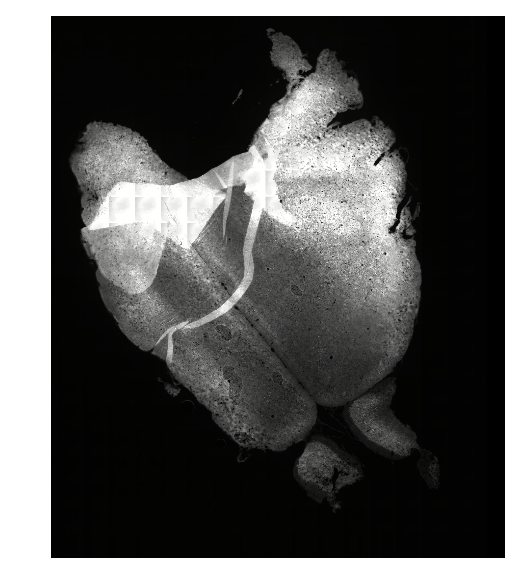

In [260]:
cShow(moving_image, moving_image)

#### do initial transform

In [261]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)

moving_resampled = sitk.Resample(moving_image, fixed_image, initial_transform, sitk.sitkLinear, 1.0, moving_image.GetPixelIDValue())

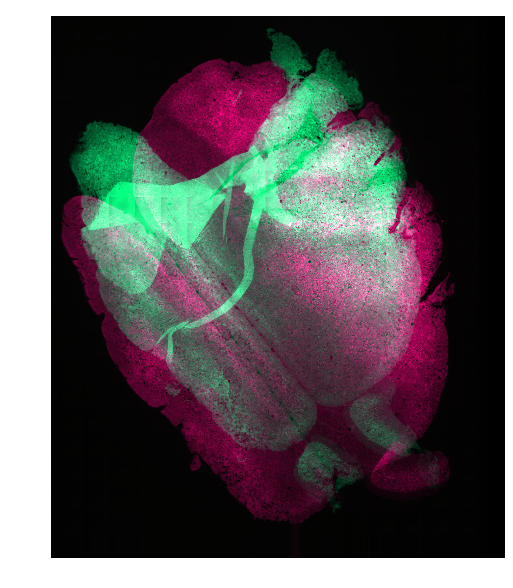

In [262]:
cShow(fixed_image, moving_resampled)

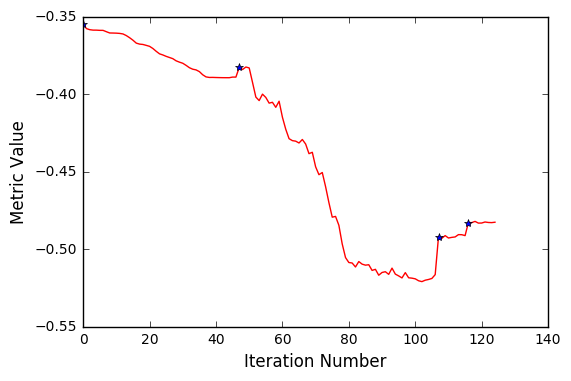

In [271]:
registration_method = sitk.ImageRegistrationMethod()

#similarity metric settings
registration_method.SetMetricAsCorrelation()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)

registration_method.SetInterpolator(sitk.sitkLinear)

#optimizer settings
registration_method.SetOptimizerAsGradientDescent(learningRate=2.0, numberOfIterations=500, convergenceMinimumValue=1e-10, convergenceWindowSize=10)
registration_method.SetOptimizerScalesFromPhysicalShift()

#setup for the multi-resolution framework            
registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [8,4,2,1])
registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4,2,1,0])
registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

#don't optimize in-place, we would possibly like to run this cell multiple times
registration_method.SetInitialTransform(initial_transform, inPlace=False)

#connect all of the observers so that we can perform plotting during registration
registration_method.AddCommand(sitk.sitkStartEvent, start_plot)
registration_method.AddCommand(sitk.sitkEndEvent, end_plot)
registration_method.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
registration_method.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(registration_method))

final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                              sitk.Cast(moving_image, sitk.sitkFloat32))

In [272]:
print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))

Final metric value: -0.482814439809
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 9.


In [273]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())

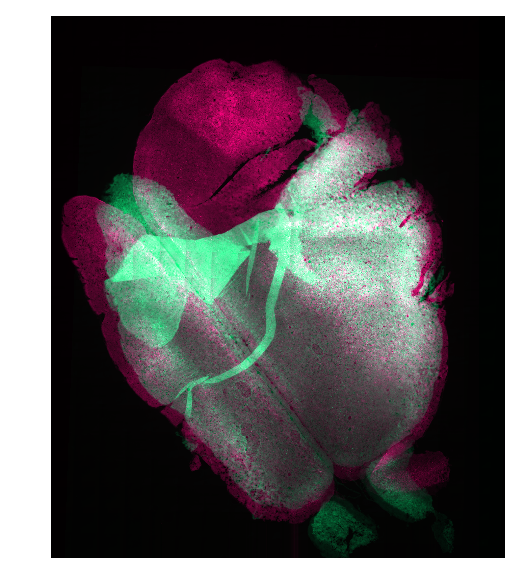

In [274]:
cShow(fixed_image, moving_resampled)

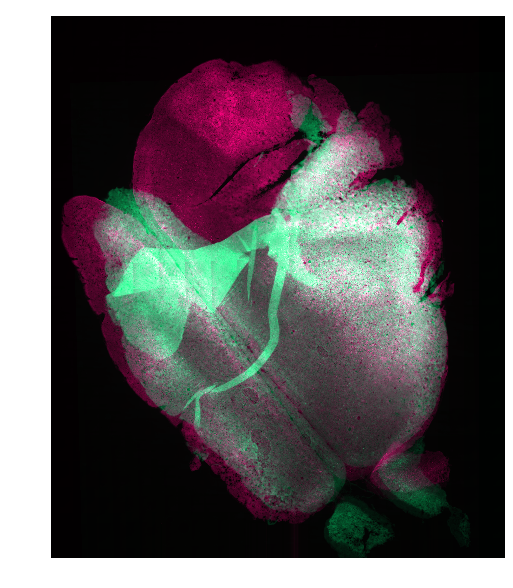

In [266]:
cShow(fixed_image, moving_resampled)

In [233]:
def multires_registration(fixed_image, moving_image, initial_transform):
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMeanSquares()
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)
    registration_method.SetInterpolator(sitk.sitkLinear)
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=500, estimateLearningRate=registration_method.Once)
    registration_method.SetOptimizerScalesFromPhysicalShift() 
    registration_method.SetInitialTransform(initial_transform)
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas = [2,1,0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    final_transform = registration_method.Execute(fixed_image, moving_image)
    print('Final metric value: {0}'.format(registration_method.GetMetricValue()))
    print('Optimizer\'s stopping condition, {0}'.format(registration_method.GetOptimizerStopConditionDescription()))
    return final_transform

In [234]:
initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
registration_method = sitk.ImageRegistrationMethod()
registration_method.SetMetricAsMeanSquares()
registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
registration_method.SetMetricSamplingPercentage(0.01)
registration_method.SetInterpolator(sitk.sitkLinear)
registration_method.SetOptimizerAsExhaustive(numberOfSteps=[4,4,4,4], stepLength = pi)

#Perform the registration in-place so that the initial_transform is modified.
registration_method.SetInitialTransform(initial_transform, inPlace=True)
registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32))

final_transform = multires_registration(sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32), initial_transform)

Final metric value: 0.0712553236837
Optimizer's stopping condition, GradientDescentOptimizerv4Template: Convergence checker passed at iteration 98.


In [241]:
moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())

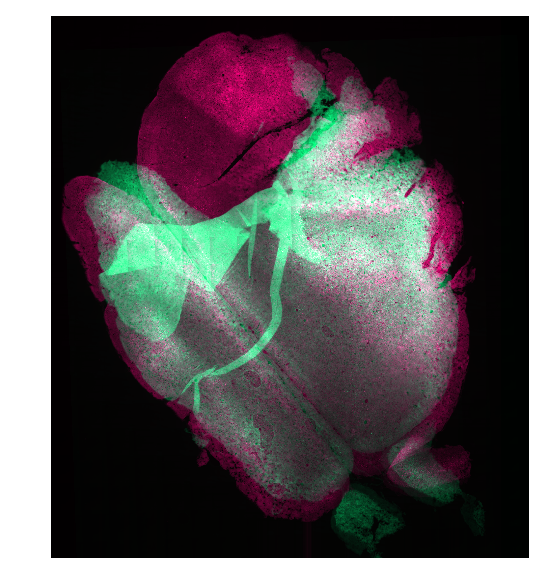

In [242]:
cShow(fixed_image, moving_resampled)

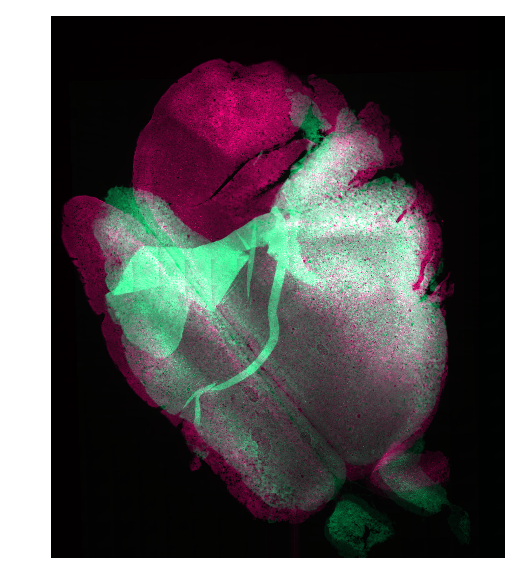

In [132]:
cShow(fixed_image, moving_resampled)

In [72]:
def align_stack(data):
    aligned = []
    for i in range(len(data)):
        if i == 0:
            aligned.append(data[i, 1])
        else:
            fixed_image = sitk.GetImageFromArray(data[i-1, 1])
            moving_image = sitk.GetImageFromArray(data[i, 1])
            
            initial_transform = sitk.CenteredTransformInitializer(fixed_image, 
                                                      moving_image, 
                                                      sitk.Euler2DTransform(), 
                                                      sitk.CenteredTransformInitializerFilter.GEOMETRY)
            
            registration_method = sitk.ImageRegistrationMethod()

            #similarity metric settings
            registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
            registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
            registration_method.SetMetricSamplingPercentage(0.01)

            registration_method.SetInterpolator(sitk.sitkLinear)

            #optimizer settings
            registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
            registration_method.SetOptimizerScalesFromPhysicalShift()

            #setup for the multi-resolution framework            
            registration_method.SetShrinkFactorsPerLevel(shrinkFactors = [4,2,1])
            registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2,1,0])
            registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

            #don't optimize in-place, we would possibly like to run this cell multiple times
            registration_method.SetInitialTransform(initial_transform, inPlace=False)

            final_transform = registration_method.Execute(sitk.Cast(fixed_image, sitk.sitkFloat32), 
                                                          sitk.Cast(moving_image, sitk.sitkFloat32))

            moving_resampled = sitk.Resample(moving_image, fixed_image, final_transform, sitk.sitkLinear, 0.0, moving_image.GetPixelIDValue())
            
            aligned.append(sitk.GetArrayFromImage(moving_resampled))
        
    return asarray(aligned)
            

In [73]:
alig = align_stack(data)

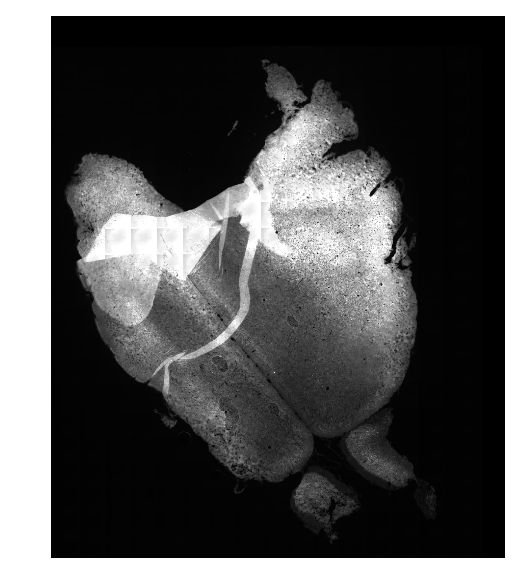

In [75]:
image(alig[1])

In [79]:
imsave(directory + 'exAl.tif', alig, plugin='tifffile', photometric='minisblack')

In [82]:
fixed_image = sitk.GetImageFromArray(alig[0])
moving_image = sitk.GetImageFromArray(alig[1])

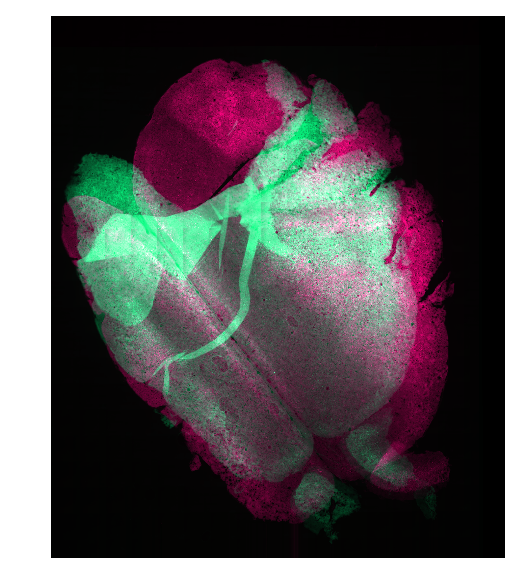

In [83]:
cShow(fixed_image, moving_image)

In [170]:
src = asarray([[a[0][1], a[0][0]] for a in x])
dst = asarray([[a[1][1], a[1][0]] for a in x])

tform = AffineTransform()
tform.estimate(src, dst)
warped = warp(A, tform, output_shape=B.shape)

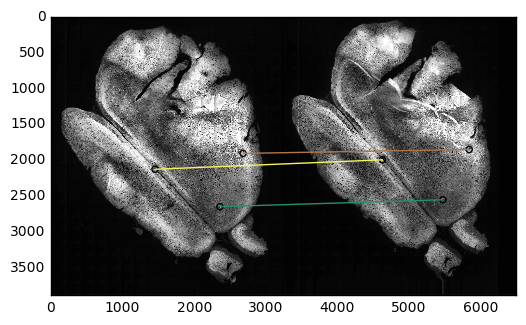

In [171]:
fig, ax = plt.subplots(nrows=1, ncols=1)

plot_matches(ax,A, B, src, dst, asarray(zip(range(len(src)), range(len(dst)))))

In [172]:
mer = asarray([warped, B])

In [173]:
imsave(directory + 'exM3.tif', mer.astype('float32'), plugin='tifffile', photometric='minisblack')

In [178]:
from skimage.viewer.canvastools import PaintTool

/Users/nick/anaconda/lib/python2.7/site-packages/skimage/viewer/utils/core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "


In [182]:
from numpy import shape

In [190]:
from mesoscope.CC import findcenters

In [251]:
aaa = (300-img).clip(0, 300)

In [239]:
bbb = findcentersXXX(aaa, 11, 0.001, .2)

In [244]:
xx = findcenters(aaa, 20, 0.001, .1);

In [245]:
len(xx)

23

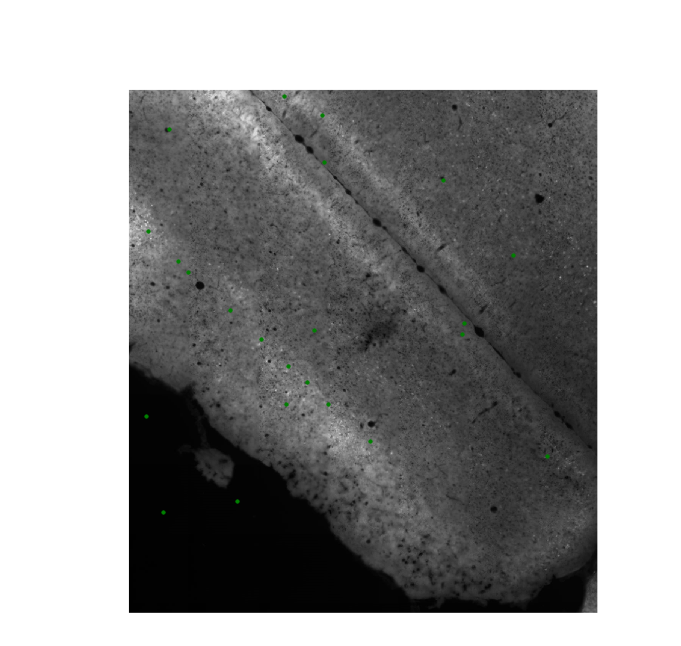

In [254]:
img = A
clim = 300

fig = plt.figure(figsize=[6, 6.0*img.shape[0]/img.shape[1]]);
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None);
ax = plt.subplot(111) 
#ax = plt.gca();
im = image(img, clim=(0, clim), ax=ax);
plt.plot(xx[:,0], xx[:,1], '.g', ms=5);

In [204]:
from mesoscope.utils import norm

In [117]:
import matplotlib.pyplot as plt

In [118]:
from skimage.feature import ORB

In [119]:
descriptor_extractor = ORB(n_keypoints=200)

descriptor_extractor.detect_and_extract(A)
keypoints1 = descriptor_extractor.keypoints
descriptors1 = descriptor_extractor.descriptors

descriptor_extractor.detect_and_extract(B)
keypoints2 = descriptor_extractor.keypoints
descriptors2 = descriptor_extractor.descriptors

In [120]:
from skimage.feature import match_descriptors, plot_matches

In [121]:
matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

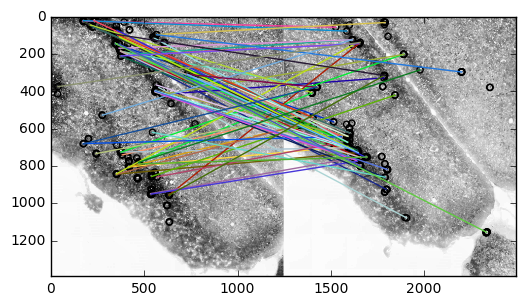

In [122]:
fig, ax = plt.subplots(nrows=1, ncols=1)

plot_matches(ax,A, B, keypoints1, keypoints2, matches12)

In [87]:
import skimage.transform as tf

In [ ]:
tf.

In [88]:
from skimage.exposure import equalize_adapthist

In [86]:
from skimage.transform import warp, AffineTransform
from skimage.measure import ransac

ImportError: cannot import name EuclideanTransform

In [112]:
# robustly estimate affine transform model with RANSAC
model_robust, inliers = ransac((keypoints1, keypoints2), AffineTransform, min_samples=3,
                               residual_threshold=10, max_trials=1000)

In [113]:
from numpy import nonzero, column_stack

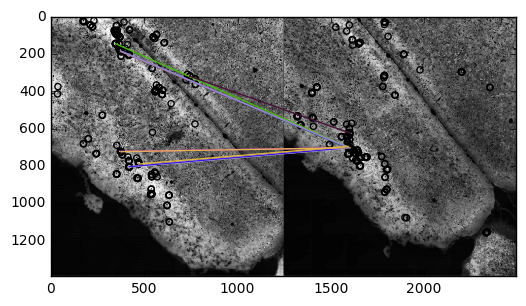

In [114]:
inlier_idxs = nonzero(inliers)[0]
fig, ax = plt.subplots(nrows=1, ncols=1)
plot_matches(ax,A, B, keypoints1, keypoints2, column_stack((inlier_idxs, inlier_idxs)))

In [84]:
tform = AffineTransform()
tform.estimate(keypoints1[inlier_idxs], keypoints2[inlier_idxs])
warped = warp(A, tform, output_shape=B.shape)

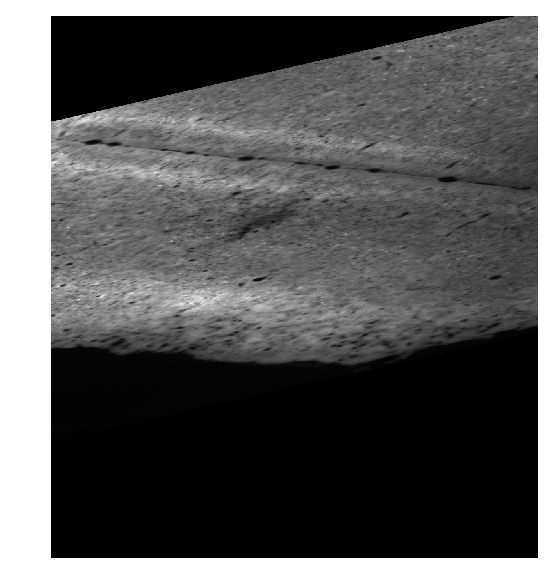

In [85]:
image(warped);

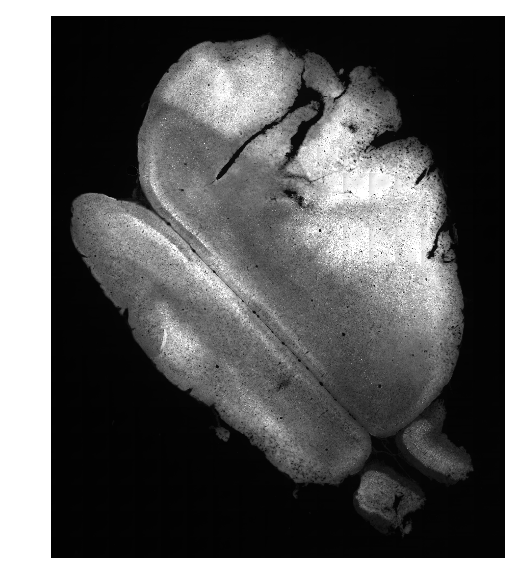

In [90]:
image(data[2,1], ax=ax)

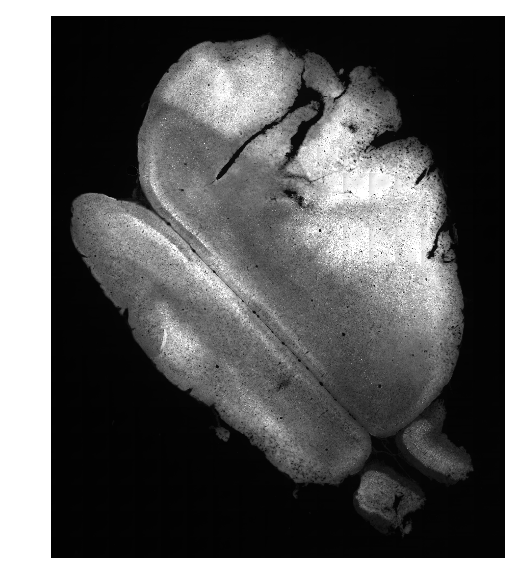

In [45]:
image(dataB[0,1].toarray());

In [22]:
x = data[0].toarray()

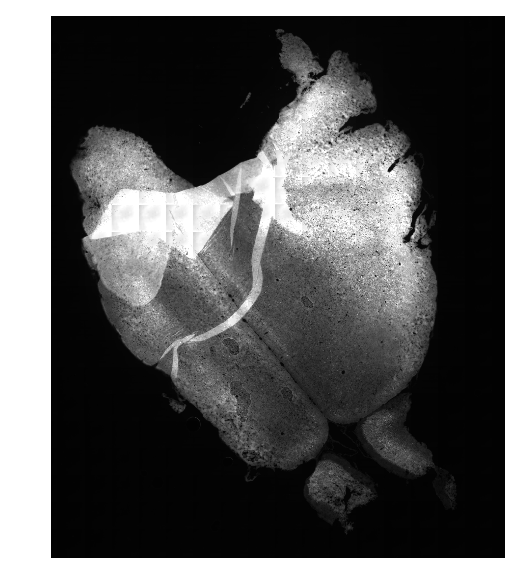

In [46]:
image(data[0,1].toarray())